<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1">Preparation</a></span><ul class="toc-item"><li><span><a href="#Load-files" data-toc-modified-id="Load-files-1.1">Load files</a></span></li></ul></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span><ul class="toc-item"><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-2.1">Helper functions</a></span></li><li><span><a href="#Metric-functions" data-toc-modified-id="Metric-functions-2.2">Metric functions</a></span><ul class="toc-item"><li><span><a href="#All-metrics" data-toc-modified-id="All-metrics-2.2.1">All metrics</a></span></li><li><span><a href="#Gaze-data" data-toc-modified-id="Gaze-data-2.2.2">Gaze data</a></span></li><li><span><a href="#Fixation-data" data-toc-modified-id="Fixation-data-2.2.3">Fixation data</a></span></li><li><span><a href="#Event-data" data-toc-modified-id="Event-data-2.2.4">Event data</a></span></li></ul></li></ul></li><li><span><a href="#Testing-metrics" data-toc-modified-id="Testing-metrics-3">Testing metrics</a></span><ul class="toc-item"><li><span><a href="#Baseline-Analysis" data-toc-modified-id="Baseline-Analysis-3.1">Baseline Analysis</a></span></li><li><span><a href="#FXD-Analysis" data-toc-modified-id="FXD-Analysis-3.2">FXD Analysis</a></span></li><li><span><a href="#EVD-Analysis" data-toc-modified-id="EVD-Analysis-3.3">EVD Analysis</a></span></li><li><span><a href="#GZD-Analysis" data-toc-modified-id="GZD-Analysis-3.4">GZD Analysis</a></span></li></ul></li><li><span><a href="#Transforming-data" data-toc-modified-id="Transforming-data-4">Transforming data</a></span><ul class="toc-item"><li><span><a href="#Additional-data" data-toc-modified-id="Additional-data-4.1">Additional data</a></span><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-4.1.1">Overview</a></span></li><li><span><a href="#Top-25%" data-toc-modified-id="Top-25%-4.1.2">Top 25%</a></span></li><li><span><a href="#Bottom-25%" data-toc-modified-id="Bottom-25%-4.1.3">Bottom 25%</a></span></li></ul></li></ul></li><li><span><a href="#Features-comparison" data-toc-modified-id="Features-comparison-5">Features comparison</a></span><ul class="toc-item"><li><span><a href="#Correlation-analysis" data-toc-modified-id="Correlation-analysis-5.1">Correlation analysis</a></span><ul class="toc-item"><li><span><a href="#Top-25%" data-toc-modified-id="Top-25%-5.1.1">Top 25%</a></span></li><li><span><a href="#Bottom-25%" data-toc-modified-id="Bottom-25%-5.1.2">Bottom 25%</a></span></li></ul></li><li><span><a href="#Correlation-plots" data-toc-modified-id="Correlation-plots-5.2">Correlation plots</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Time-on-task" data-toc-modified-id="Time-on-task-5.2.0.1">Time on task</a></span></li><li><span><a href="#Total-fixations" data-toc-modified-id="Total-fixations-5.2.0.2">Total fixations</a></span></li><li><span><a href="#Mean-fixations-durations" data-toc-modified-id="Mean-fixations-durations-5.2.0.3">Mean fixations durations</a></span></li><li><span><a href="#Mean-time-between-clicks" data-toc-modified-id="Mean-time-between-clicks-5.2.0.4">Mean time between clicks</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Other-analysis" data-toc-modified-id="Other-analysis-6">Other analysis</a></span></li></ul></div>

<h1>Eye Gaze Data Processing<span class="tocSkip"></span></h1>

Following metrics from: https://github.com/TheD2Lab/Eye.Tracking.Data.Analysis.For.Tobii.2150/tree/master/src/analysis

- Isaac Cortes
- Reynaldo Suarez
- Chris
- Janki

In [1]:
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random 
import math

# Preparation

## Load files

In [2]:
def load_files(participant = 1):
    
    route = f'datasets/p{participant}/p{participant}'
    
    # Load one of the files to create functions
    baseline_cols = ['number', 'time', 'l_screen_x', 'l_screen_y', 'l_cam_x', 'l_cam_y', 'l_distance', 
                'l_pupil', 'l_code', 'r_screen_x', 'r_screen_y', 'r_cam_x', 'r_cam_y', 'r_distance', 
                'r_pupil', 'r_code']

    baseline = pd.read_csv(f'{route}GZD.txt', sep='\t', names = baseline_cols, on_bad_lines='skip')
    
    # Load FXD graph and tree
    fxd_cols = ['number', 'time', 'duration', 'screen_x', 'screen_y']

    fxd_graph = pd.read_csv(f'{route}.graphFXD.txt', sep='\t', names = fxd_cols, on_bad_lines='skip')
    fxd_tree = pd.read_csv(f'{route}.treeFXD.txt', sep='\t', names = fxd_cols, on_bad_lines='skip')

    # Load EVD graph and tree
    evd_cols = ['time', 'event', 'event_key', 'data1', 'data2', 'description']

    evd_graph = pd.read_csv(f'{route}.graphEVD.txt', sep='\t', names = evd_cols, on_bad_lines='skip')
    evd_tree = pd.read_csv(f'{route}.treeEVD.txt', sep='\t', names = evd_cols, on_bad_lines='skip')
    
    # Load GZD graph and tree
    gzd_cols = ['number', 'time', 'l_screen_x', 'l_screen_y', 'l_cam_x', 'l_cam_y', 'l_distance', 
                'l_pupil', 'l_code', 'r_screen_x', 'r_screen_y', 'r_cam_x', 'r_cam_y', 'r_distance', 
                'r_pupil', 'r_code']

    gzd_graph = pd.read_csv(f'{route}.graphGZD.txt', sep='\t', names = gzd_cols, on_bad_lines='skip')
    gzd_tree = pd.read_csv(f'{route}.treeGZD.txt', sep='\t', names = gzd_cols, on_bad_lines='skip')

    return baseline, fxd_graph, fxd_tree, evd_graph, evd_tree, gzd_graph, gzd_tree


In [3]:
# Not all numbers 1-36 are participants in folder, use random choose instead with the folder contents
participant = random.randint(1,36)
print(f'Participant: {participant}')

baseline, fxd_graph, fxd_tree, evd_graph, evd_tree, gzd_graph, gzd_tree = load_files(participant)

Participant: 11


# Functions

## Helper functions

$$d = \sqrt{(x_2 - x_1)^2 + (y_2-y_1)^2}$$

In [4]:
def distance(row):
    x1, y1 = row['x'], row['y']
    x2, y2 =  row['next_x'], row['next_y']
    dist = math.sqrt(math.pow((x2-x1), 2) + math.pow((y2-y1), 2))
    row['dist'] = dist
    
    return row

$$dur = T2-(T1+D1)$$

In [5]:
def duration(row):
    
    t1, d1 = row['time'], row['duration']
    t2 = row['next_time']
    duration = t2 - (t1+d1)
    row['duration_between_fixations'] = duration
    
    return row 

## Metric functions

### All metrics

In [6]:
def get_metrics_df(row):
    
    participant = ''.join(filter(str.isdigit, row['ID']))
    print(participant)
    
    visualization = row['Visualization']
    
    # Load data for participant
    baseline, fxd_graph, fxd_tree, evd_graph, evd_tree, gzd_graph, gzd_tree = load_files(participant)
    
    # Baseline gaze data
    base_avg_size_left, base_avg_size_right, base_avg_size_both = get_gaze_metrics(baseline)
    # Graph data
    if visualization == 1:
        # Fixations data
        total_fixations, sum_fixation_duration, mean_fixation_duration, std_fixation_duration = get_fixation_metrics(fxd_graph)
        # Saccade length data
        total_saccades, sum_saccade_length, mean_saccade_length, std_saccade_length = get_saccade_length_metrics(fxd_graph)
        # Saccade duration data
        sum_saccade_duration, mean_saccade_duration, std_saccade_duration = get_saccade_durations_metrics(fxd_graph)
        # Event data
        total_left_clicks, mean_time_between_clicks, std_time_between_clicks = get_event_metrics(evd_graph)
        # Gaze data
        avg_size_left, avg_size_right, avg_size_both = get_gaze_metrics(gzd_graph)
    # Tree data
    else:
        # Fixations data
        total_fixations, sum_fixation_duration, mean_fixation_duration, std_fixation_duration = get_fixation_metrics(fxd_tree)
        # Saccade length data
        total_saccades, sum_saccade_length, mean_saccade_length, std_saccade_length = get_saccade_length_metrics(fxd_tree)
        # Saccade duration data
        sum_saccade_duration, mean_saccade_duration, std_saccade_duration = get_saccade_durations_metrics(fxd_tree)
        # Event data
        total_left_clicks, mean_time_between_clicks, std_time_between_clicks = get_event_metrics(evd_tree)
        # Gaze data
        avg_size_left, avg_size_right, avg_size_both = get_gaze_metrics(gzd_tree)
    
    cols = ['base_avg_size_left', 'base_avg_size_right', 
            'base_avg_size_both', 'total_fixations', 'sum_fixation_duration', 
            'mean_fixation_duration', 'std_fixation_duration', 'total_saccades', 
            'sum_saccade_length', 'mean_saccade_length', 'std_saccade_length', 
            'sum_saccade_duration', 'mean_saccade_duration', 'std_saccade_duration', 
            'total_left_clicks', 'mean_time_between_clicks', 'std_time_between_clicks', 
            'avg_size_left', 'avg_size_right', 'avg_size_both']
    
    data = [base_avg_size_left, base_avg_size_right, 
            base_avg_size_both, total_fixations, sum_fixation_duration, 
            mean_fixation_duration, std_fixation_duration, total_saccades, 
            sum_saccade_length, mean_saccade_length, std_saccade_length, sum_saccade_duration, 
            mean_saccade_duration, std_saccade_duration, total_left_clicks, 
            mean_time_between_clicks, std_time_between_clicks, 
            avg_size_left, avg_size_right, avg_size_both]
    
    for i in range(len(cols)):
        row[cols[i]] = data[i]
    
    return row

### Gaze data

In [7]:
def get_gaze_metrics(df):
    
    # A code with 0 indicates the eye tracker was confdident with this data
    # Filtering only records where both pupil sizes are valid
    df = df[(df['l_code'] == 0) & (df['r_code'] == 0)]
    avg_size_left = df["l_pupil"].mean()
    avg_size_right = df["r_pupil"].mean()
    avg_size_both = pd.concat([df["r_pupil"],df["l_pupil"]]).mean()
    
    return avg_size_left, avg_size_right, avg_size_both

In [8]:
def print_gaze_metrics(df):
    avg_size_left, avg_size_right, avg_size_both = get_gaze_metrics(df)

    print(f'Avg. pupil size of the left eye: {avg_size_left:.4f}')
    print(f'Avg. pupil size of the right eye: {avg_size_right:.4f}')
    print(f'Avg. pupil size of both eyes: {avg_size_both:.4f}')

### Fixation data

In [9]:
def get_fixation_metrics(df):
    
    total_fixations = len(df)
    sum_fixation_duration_sec = df["duration"].sum() / 1000
    mean_fixation_duration = df["duration"].mean()
    std_fixation_duration = df["duration"].std()
    
    return total_fixations, sum_fixation_duration_sec, mean_fixation_duration, std_fixation_duration
    
def get_saccade_length_metrics(df):
    
    # Get distances of all points
    coords = df[['screen_x','screen_y']].copy()
    coords = coords.rename({'screen_x':'x','screen_y':'y'}, axis='columns')
    coords['next_x'] = coords['x'].shift(-1)
    coords['next_y'] = coords['y'].shift(-1)
    coords = coords.apply(distance, axis=1)
    coords.dropna(inplace=True)
    
    total_saccades = len(coords)
    sum_saccade_length = coords['dist'].sum()
    mean_saccade_length = coords['dist'].mean()
    std_saccade_length = coords['dist'].std()
        
    return total_saccades, sum_saccade_length, mean_saccade_length, std_saccade_length

def get_saccade_durations_metrics(df):
    
    # Get duration of all saccades
    saccadeDetails = df[['time','duration']].copy()
    saccadeDetails['next_time'] = saccadeDetails['time'].shift(-1)
    saccadeDetails['next_duration'] = saccadeDetails['duration'].shift(-1)
    saccadeDetails = saccadeDetails.apply(duration, axis=1)
    saccadeDetails.dropna(inplace=True)
    
    sum_saccade_duration_sec = saccadeDetails['duration_between_fixations'].sum() / 1000
    mean_saccade_duration = saccadeDetails['duration_between_fixations'].mean()
    std_saccade_duration = saccadeDetails['duration_between_fixations'].std()
    
    return sum_saccade_duration_sec, mean_saccade_duration, std_saccade_duration

In [10]:
def print_fixation_metrics(df):
    # Fixations
    total_fixations, sum_fixation_duration_sec, mean_fixation_duration, std_fixation_duration = get_fixation_metrics(df)
    print(f'{"="*10} {"Fixations":^20} {"="*10}')
    print(f'Total number of fixations: {total_fixations}')
    print(f'Sum of all fixation durations: {sum_fixation_duration_sec}s')
    print(f'Sum of all fixation durations: {sum_fixation_duration_sec / 60 :.2f}min')
    print(f'Mean fixation duration: {mean_fixation_duration:.2f}ms')
    print(f'StDev fixation duration: {std_fixation_duration:.2f}ms')

    # Saccade 
    total_saccades, sum_saccade_length, mean_saccade_length, std_saccade_length = get_saccade_length_metrics(df)
    print(f'\n{"="*10} {"Saccade lengths":^20} {"="*10}')
    print(f'Total number of saccades: {total_saccades}')
    print(f'Sum of all saccade lengths: {sum_saccade_length:.2f}px')
    print(f'Mean saccade length: {mean_saccade_length:.2f}px')
    print(f'StDev saccade length: {std_saccade_length:.2f}px')

    # Durations
    sum_saccade_duration_sec, mean_saccade_duration, std_saccade_duration = get_saccade_durations_metrics(df)
    print(f'\n{"="*10} {"Saccade durations":^20} {"="*10}')
    print(f'Sum of all saccade durations: {sum_saccade_duration_sec:.2f}s')
    print(f'Sum of all saccade durations: {sum_saccade_duration_sec / 60 :.2f}min')
    print(f'Mean saccade duration: {mean_saccade_duration:.2f}ms')
    print(f'StDev saccade duration: {std_saccade_duration:.2f}ms')

### Event data

In [11]:
def get_event_metrics(df):
    
    lclicks = df[df['event'] == 'LMouseButton']
    lclicks = lclicks[['time','data1','data2']]
    lclicks['next_time'] = lclicks['time'].shift(-1)
    lclicks['time_between'] = lclicks['next_time'] - lclicks['time']
    lclicks.dropna(inplace=True)

    total_L_clicks = len(lclicks)
    avg_time_between_clicks_sec = lclicks['time_between'].mean() / 1000
    std_time_between_clicks_sec = lclicks['time_between'].std() / 1000
    
    return total_L_clicks, avg_time_between_clicks_sec, std_time_between_clicks_sec

In [12]:
def print_event_metrics(df):
    
    total_L_clicks, avg_time_between_clicks_sec, std_time_between_clicks_sec = get_event_metrics(df)
    
    print(f'Total number of L mouse clicks: {total_L_clicks}')
    print(f'Avg. amount of time between clicks: {avg_time_between_clicks_sec:.2f}s')
    print(f'StDev amount of time between clicks: {std_time_between_clicks_sec:.2f}s')

# Testing metrics

## Baseline Analysis

- average pupil size of left eye; 
- average pupil size of right eye; 
- average pupil size of both eyes.

In [13]:
baseline.head()

,number,time,l_screen_x,l_screen_y,l_cam_x,l_cam_y,l_distance,l_pupil,l_code,r_screen_x,r_screen_y,r_cam_x,r_cam_y,r_distance,r_pupil,r_code
0,17,1,-1280,-1024,0.711,0.762,-1.000,-1.000,4,-1280,-1024,0.513,0.759,-1.000,-1.000,4
1,37,2,-1280,-1024,-1.000,-1.000,-1.000,-1.000,4,-1280,-1024,-1.000,-1.000,-1.000,-1.000,4
2,57,3,610,369,0.712,0.762,878.575,4.345,0,577,388,0.514,0.758,871.288,3.982,0
3,77,4,573,372,0.712,0.762,878.575,4.391,0,591,377,0.514,0.758,871.288,3.917,0
4,96,5,575,339,0.712,0.762,878.575,4.386,0,582,384,0.514,0.758,871.288,3.989,0


In [14]:
%%time
print_gaze_metrics(baseline)

Avg. pupil size of the left eye: 4.1062
Avg. pupil size of the right eye: 3.7313
Avg. pupil size of both eyes: 3.9187
Wall time: 3.03 ms


## FXD Analysis

**Fixations**
- total number of fixations
- sum of all fixation duration
- mean duration
- StDev of durations

**Saccade lengths**
- total number of saccades
- sum of all saccade length
- mean saccade length
- StDev of saccade lengths

**Saccade durations**
- sum of all saccade durations
- mean saccade duration
- StDev of saccade durations

**Research**
- scanpath duration
- fixation to saccade ratio

In [15]:
fxd_graph.head()

,number,time,duration,screen_x,screen_y
0,1,186,199,662,497
1,2,764,100,58,237
2,3,1322,140,298,218
3,4,1661,180,285,234
4,5,2060,199,281,896


In [16]:
%%time
print_fixation_metrics(fxd_graph)

==========      Fixations       ==========
Total number of fixations: 3657
Sum of all fixation durations: 579.093s
Sum of all fixation durations: 9.65min
Mean fixation duration: 158.35ms
StDev fixation duration: 69.69ms

==========   Saccade lengths    ==========
Total number of saccades: 3656
Sum of all saccade lengths: 518608.36px
Mean saccade length: 141.85px
StDev saccade length: 195.26px

==========  Saccade durations   ==========
Sum of all saccade durations: 1404.63s
Sum of all saccade durations: 23.41min
Mean saccade duration: 384.20ms
StDev saccade duration: 727.41ms
Wall time: 3.9 s


In [17]:
fxd_tree.head()

,number,time,duration,screen_x,screen_y
0,1,344,120,197,205
1,2,2377,419,12,546
2,3,2816,180,2,550
3,4,3414,100,80,589
4,5,3553,379,67,591


In [18]:
%%time
print_fixation_metrics(fxd_tree)

==========      Fixations       ==========
Total number of fixations: 1152
Sum of all fixation durations: 165.166s
Sum of all fixation durations: 2.75min
Mean fixation duration: 143.37ms
StDev fixation duration: 54.00ms

==========   Saccade lengths    ==========
Total number of saccades: 1151
Sum of all saccade lengths: 186921.16px
Mean saccade length: 162.40px
StDev saccade length: 230.68px

==========  Saccade durations   ==========
Sum of all saccade durations: 771.72s
Sum of all saccade durations: 12.86min
Mean saccade duration: 670.48ms
StDev saccade duration: 1858.74ms
Wall time: 1.58 s


## EVD Analysis

- total number of L mouse clicks. 
- avg time between clicks.
- std time between clicks.

In [19]:
evd_graph.head()

,time,event,event_key,data1,data2,description
0,6055,LMouseButton,1,213,941,NaN
1,6852,LMouseButton,1,190,806,NaN
2,8367,LMouseButton,1,184,808,NaN
3,10510,LMouseButton,1,230,890,NaN
4,11228,LMouseButton,1,292,741,NaN


In [20]:
%%time
print_event_metrics(evd_graph)

Total number of L mouse clicks: 829
Avg. amount of time between clicks: 2.38s
StDev amount of time between clicks: 2.74s
Wall time: 7.45 ms


In [21]:
evd_tree.head()

,time,event,event_key,data1,data2,description
0,3101,LMouseButton,1,23,514,NaN
1,5284,LMouseButton,1,654,521,NaN
2,9590,LMouseButton,1,255,601,NaN
3,15212,LMouseButton,1,40,601,NaN
4,16278,LMouseButton,1,40,599,NaN


In [22]:
%%time
print_event_metrics(evd_tree)

Total number of L mouse clicks: 303
Avg. amount of time between clicks: 3.09s
StDev amount of time between clicks: 4.31s
Wall time: 5.84 ms


## GZD Analysis

- average pupil size of left eye;
- average pupil size of right eye;
- average pupil size of both eyes.

In [23]:
gzd_graph.head()

,number,time,l_screen_x,l_screen_y,l_cam_x,l_cam_y,l_distance,l_pupil,l_code,r_screen_x,r_screen_y,r_cam_x,r_cam_y,r_distance,r_pupil,r_code
0,6,1,-1280,-1024,0.717,0.754,-1.000,-1.000,4,-1280,-1024,0.518,0.749,-1.000,-1.000,4
1,26,2,-1280,-1024,-1.000,-1.000,-1.000,-1.000,4,-1280,-1024,-1.000,-1.000,-1.000,-1.000,4
2,46,3,-1280,-1024,0.716,0.754,-1.000,-1.000,4,-1280,-1024,0.517,0.749,-1.000,-1.000,4
3,66,4,744,370,0.715,0.754,868.618,3.954,0,727,383,0.516,0.749,859.095,3.771,0
4,86,5,750,396,0.713,0.754,868.618,3.957,0,734,380,0.514,0.750,859.095,3.663,0


In [24]:
%%time
print_gaze_metrics(gzd_graph)

Avg. pupil size of the left eye: 4.0077
Avg. pupil size of the right eye: 3.5584
Avg. pupil size of both eyes: 3.7831
Wall time: 22.3 ms


In [25]:
gzd_tree.head()

,number,time,l_screen_x,l_screen_y,l_cam_x,l_cam_y,l_distance,l_pupil,l_code,r_screen_x,r_screen_y,r_cam_x,r_cam_y,r_distance,r_pupil,r_code
0,5,1,-1280,-1024,-1.000,-1.000,-1.0,-1.0,4,-1280,-1024,-1.000,-1.000,-1.0,-1.0,4
1,25,2,-1280,-1024,0.762,0.783,-1.0,-1.0,4,-1280,-1024,0.567,0.779,-1.0,-1.0,4
2,44,3,-1280,-1024,-1.000,-1.000,-1.0,-1.0,4,-1280,-1024,-1.000,-1.000,-1.0,-1.0,4
3,64,4,-1280,-1024,0.762,0.779,-1.0,-1.0,4,-1280,-1024,0.568,0.776,-1.0,-1.0,4
4,84,5,-1280,-1024,0.763,0.778,-1.0,-1.0,4,-1280,-1024,0.568,0.775,-1.0,-1.0,4


In [26]:
%%time
print_gaze_metrics(gzd_tree)

Avg. pupil size of the left eye: 3.9083
Avg. pupil size of the right eye: 3.5320
Avg. pupil size of both eyes: 3.7201
Wall time: 11.9 ms


# Transforming data

## Additional data

In [27]:
add_data = pd.read_csv('datasets/additional_participant_data.csv')

In [28]:
add_data['Ontologies'] = add_data['Ontologies'].map({1: 'Conference Domain', 2: 'Biomedical Domain'})
add_data['Visualization'] = add_data['Visualization'].map({1: 'Tree', 2: 'Graph'})

In [29]:
add_data.head()

,ID,Ontologies,Visualization,Task_Success,Time_On_Task
0,p1,Conference Domain,Tree,0.608696,26
1,p1,Biomedical Domain,Graph,0.521739,38
2,p3,Conference Domain,Tree,0.478261,10
3,p3,Biomedical Domain,Graph,0.391304,50
4,p5,Conference Domain,Tree,0.521739,22


In [30]:
add_data[['Task_Success']].quantile([0.25,0.5,0.75])

,Task_Success
0.25,0.391304
0.50,0.478261
0.75,0.565217


In [31]:
pd.qcut(add_data['Task_Success'], 4)

0      (0.565, 0.87]
1     (0.478, 0.565]
2     (0.391, 0.478]
3     (0.086, 0.391]
4     (0.478, 0.565]
           ...      
57    (0.086, 0.391]
58     (0.565, 0.87]
59    (0.478, 0.565]
60    (0.391, 0.478]
61    (0.478, 0.565]
Name: Task_Success, Length: 62, dtype: category
Categories (4, interval[float64, right]): [(0.086, 0.391] < (0.391, 0.478] < (0.478, 0.565] < (0.565, 0.87]]

### Overview

In [32]:
# Divided by quantiles bottom 25% and top 25% value should be 19
top_bot_n = 20

In [33]:
add_data.groupby(by=['Ontologies','Visualization']).mean(numeric_only=True)

Task_Success  Time_On_Task
Ontologies        Visualization                            
Biomedical Domain Graph              0.407609     35.187500
                  Tree               0.513043     24.666667
Conference Domain Graph              0.501449     22.000000
                  Tree               0.494565     17.625000

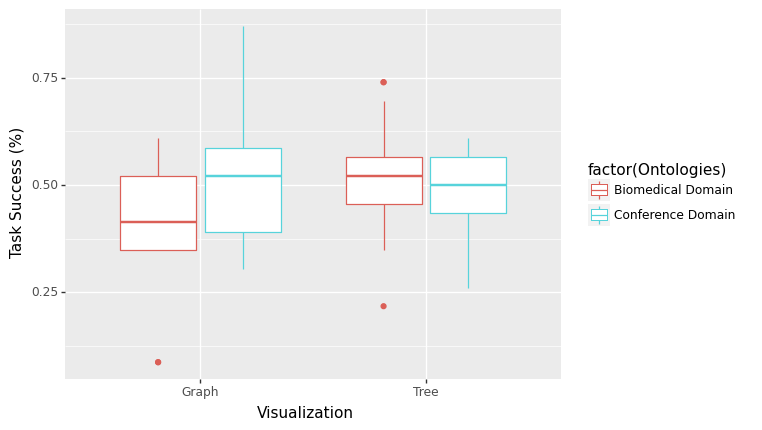

<ggplot: (118399508155)>

In [34]:
# Plotting task success distribution per visualization
(
    ggplot(add_data) +
    aes(x='factor(Visualization)', y='Task_Success', color='factor(Ontologies)') +
    geom_boxplot() +
    labs(x='Visualization', y='Task Success (%)')
)

### Top 25%

In [35]:
top = add_data.copy()
top.sort_values(by=['Task_Success','Time_On_Task'], ascending=[False,True], inplace=True)
top.reset_index(drop=True, inplace=True)
top = top.head(top_bot_n)
top

,ID,Ontologies,Visualization,Task_Success,Time_On_Task
0,p6,Conference Domain,Graph,0.869565,26
1,p18,Conference Domain,Graph,0.739130,21
2,p24,Biomedical Domain,Tree,0.739130,25
3,p6,Biomedical Domain,Tree,0.739130,43
4,p12,Biomedical Domain,Tree,0.695652,11
5,p35,Conference Domain,Tree,0.608696,9
6,p10,Conference Domain,Graph,0.608696,17
7,p17,Biomedical Domain,Graph,0.608696,22
8,p1,Conference Domain,Tree,0.608696,26
9,p34,Conference Domain,Graph,0.608696,38


In [36]:
top[['Ontologies','Visualization','Task_Success','Time_On_Task']].groupby(by=['Ontologies','Visualization']).mean(numeric_only=True)

Task_Success  Time_On_Task
Ontologies        Visualization                            
Biomedical Domain Graph              0.579710     13.666667
                  Tree               0.660870     31.000000
Conference Domain Graph              0.678261     26.800000
                  Tree               0.571429     17.285714

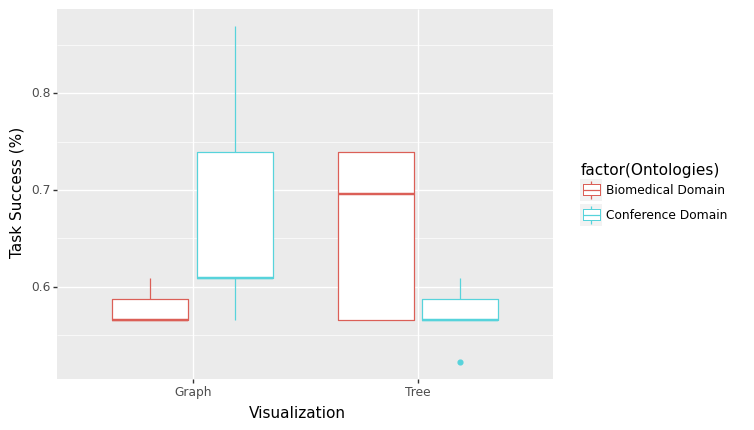

<ggplot: (118399490729)>

In [37]:
# Plotting task success distribution per visualization
(
    ggplot(top) +
    aes(x='factor(Visualization)', y='Task_Success', color='factor(Ontologies)') +
    geom_boxplot() +
    labs(x='Visualization', y='Task Success (%)')
)

In [38]:
%%time
top = top.apply(get_metrics_df, axis=1)

6
18
24
6
12
35
10
17
1
34
21
15
23
19
7
18
24
25
34
15
Wall time: 1min 16s


In [39]:
top.to_csv(f'datasets/top{top_bot_n}.csv', sep=',')

### Bottom 25%

In [40]:
bottom = add_data.copy()
bottom.sort_values(by=['Task_Success','Time_On_Task'], ascending=[True,False], inplace=True)
bottom.reset_index(drop=True, inplace=True)
bottom = bottom.head(top_bot_n)
bottom

,ID,Ontologies,Visualization,Task_Success,Time_On_Task
0,p27,Biomedical Domain,Graph,0.086957,50
1,p7,Biomedical Domain,Graph,0.086957,20
2,p14,Biomedical Domain,Tree,0.217391,28
3,p27,Conference Domain,Tree,0.260870,13
4,p32,Conference Domain,Graph,0.304348,21
5,p12,Conference Domain,Graph,0.304348,17
6,p25,Biomedical Domain,Graph,0.347826,39
7,p11,Biomedical Domain,Graph,0.347826,33
8,p33,Biomedical Domain,Graph,0.347826,27
9,p2,Conference Domain,Graph,0.347826,19


In [41]:
bottom[['Ontologies','Visualization','Task_Success','Time_On_Task']].groupby(by=['Ontologies','Visualization']).mean(numeric_only=True)

Task_Success  Time_On_Task
Ontologies        Visualization                            
Biomedical Domain Graph              0.314010     41.777778
                  Tree               0.318841     21.666667
Conference Domain Graph              0.355072     20.333333
                  Tree               0.326087     13.500000

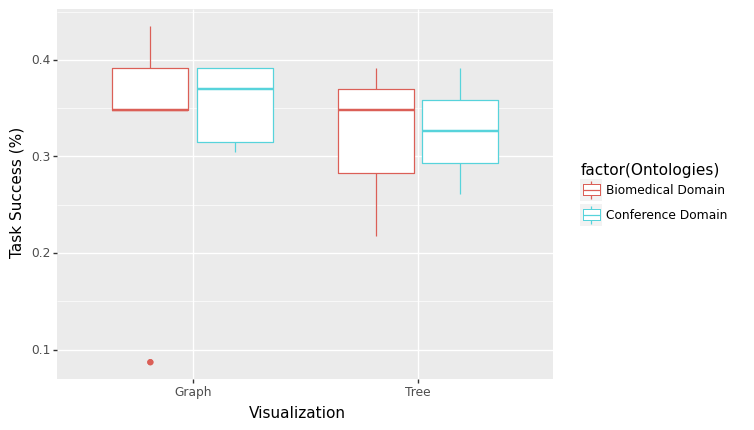

<ggplot: (118399967751)>

In [42]:
# Plotting task success distribution per visualization
(
    ggplot(bottom) +
    aes(x='factor(Visualization)', y='Task_Success', color='factor(Ontologies)') +
    geom_boxplot() +
    labs(x='Visualization', y='Task Success (%)')
)

In [43]:
%%time
bottom = bottom.apply(get_metrics_df, axis=1)

27
7
14
27
32
12
25
11
33
2
32
23
3
20
13
2
30
31
4
19
Wall time: 55.2 s


In [44]:
bottom.to_csv(f'datasets/bottom{top_bot_n}.csv', sep=',')

# Features comparison

In [45]:
df = top.copy()
df2 = bottom.copy()
df['group'] = 'Top'
df2['group'] = 'Bottom'

groups_metrics = pd.concat([df,df2])

In [46]:
groups_metrics.head()

,ID,Ontologies,Visualization,Task_Success,Time_On_Task,base_avg_size_left,base_avg_size_right,base_avg_size_both,total_fixations,sum_fixation_duration,...,sum_saccade_duration,mean_saccade_duration,std_saccade_duration,total_left_clicks,mean_time_between_clicks,std_time_between_clicks,avg_size_left,avg_size_right,avg_size_both,group
0,p6,Conference Domain,Graph,0.869565,26,3.298531,3.454790,3.376660,6752,1355.507,...,1263.480,187.154496,258.299289,666,3.901248,5.763015,3.607497,3.827016,3.717256,Top
1,p18,Conference Domain,Graph,0.739130,21,2.469319,2.319605,2.394462,3559,651.412,...,964.344,271.035413,402.456275,589,2.713365,3.518583,2.801013,2.642901,2.721957,Top
2,p24,Biomedical Domain,Tree,0.739130,25,3.604752,3.580405,3.592578,1834,258.910,...,1217.362,664.136388,1283.746475,628,2.342236,3.688549,3.881971,3.795898,3.838934,Top
3,p6,Biomedical Domain,Tree,0.739130,43,3.298531,3.454790,3.376660,6752,1355.507,...,1263.480,187.154496,258.299289,666,3.901248,5.763015,3.607497,3.827016,3.717256,Top
4,p12,Biomedical Domain,Tree,0.695652,11,3.736884,3.793618,3.765251,1132,205.727,...,459.508,406.284704,693.935532,239,2.774891,2.996201,3.810049,3.866253,3.838151,Top


In [47]:
groups_metrics.to_csv(f'datasets/groups_metrics.csv', sep=',')

In [48]:
# Mean metrics of top 25%
mean_top = top.drop(['ID','Ontologies','Visualization'], axis=1)
comp = mean_top.mean().to_frame(name='top')

# Mean metrics of bottom 25%
mean_bot = bottom.drop(['ID','Ontologies','Visualization'], axis=1)
mean_bot = mean_bot.mean().to_frame(name='bottom')
comp['bottom'] = mean_bot['bottom']

# Difference
comp['difference'] = comp['top'] - comp['bottom']
comp

,top,bottom,difference
Task_Success,0.621739,0.328261,0.293478
Time_On_Task,22.550000,29.500000,-6.950000
base_avg_size_left,3.552157,3.636023,-0.083867
base_avg_size_right,3.515580,3.532653,-0.017073
base_avg_size_both,3.533868,3.584338,-0.050470
total_fixations,3230.600000,2267.950000,962.650000
sum_fixation_duration,703.027350,622.129950,80.897400
mean_fixation_duration,214.123120,255.966187,-41.843067
std_fixation_duration,148.496752,188.699999,-40.203247
total_saccades,3229.600000,2266.950000,962.650000


In [49]:
comp.to_csv(f'datasets/groups_comparison.csv', sep=',')

## Correlation analysis

In [50]:
corr_cols = ['Task_Success', 'Time_On_Task',
        'total_fixations', 'sum_fixation_duration', 'mean_fixation_duration', 'total_saccades', 
        'sum_saccade_length','mean_saccade_length', 'sum_saccade_duration','mean_saccade_duration',
        'total_left_clicks','mean_time_between_clicks', 'std_time_between_clicks']

### Top 25%

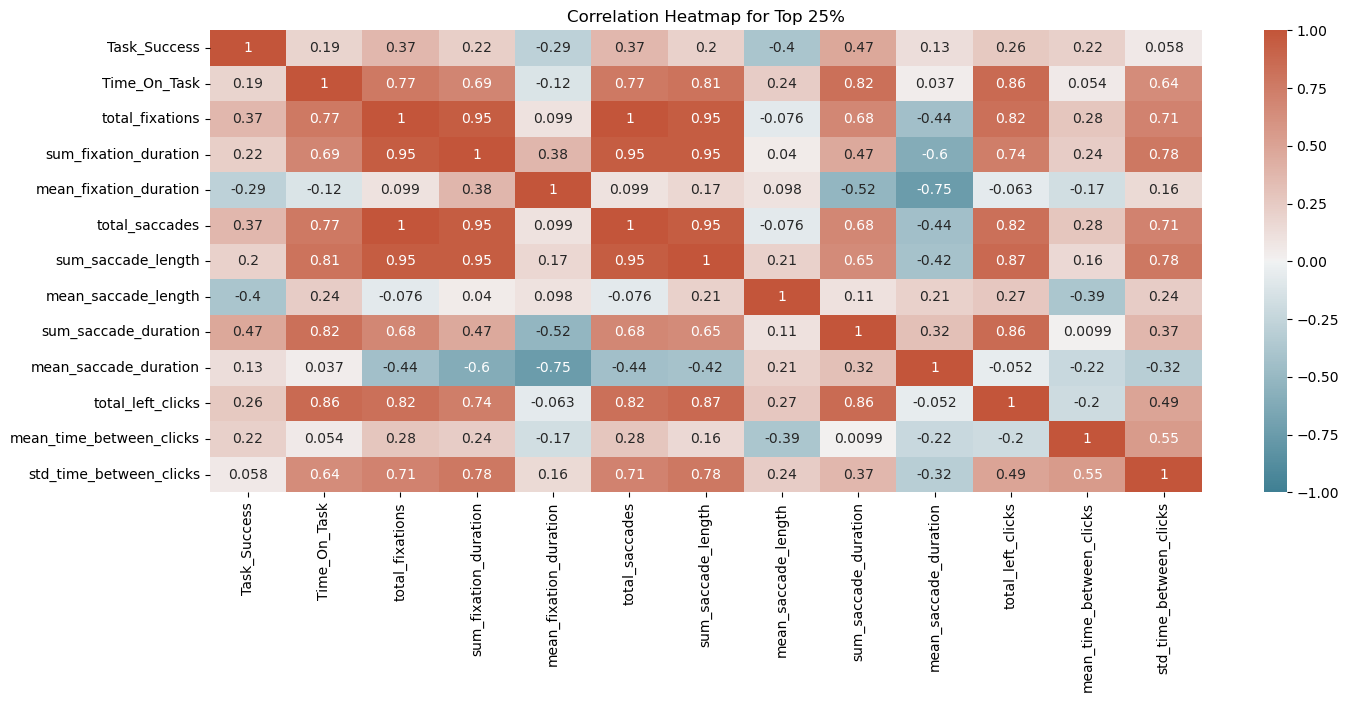

In [51]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap(top[corr_cols].corr(), vmin=-1, vmax=1, annot=True, 
                 cmap=sns.diverging_palette(220, 20, as_cmap=True))
ax.set_title('Correlation Heatmap for Top 25%')
plt.show()

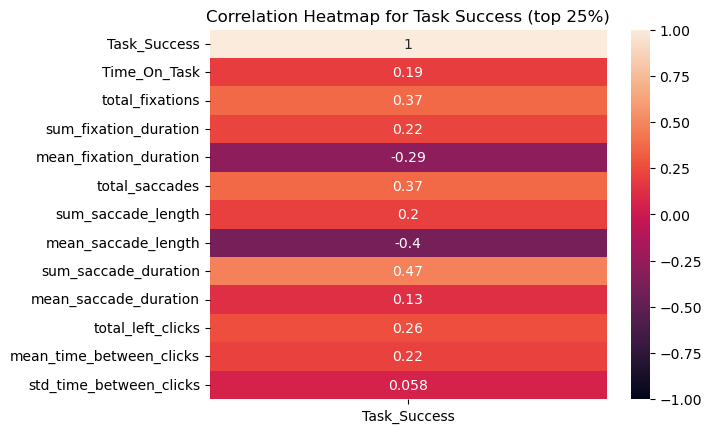

In [52]:
corr_succ = top[corr_cols].corr()[['Task_Success']]
ax = sns.heatmap(corr_succ, vmin=-1, vmax=1, annot=True)
ax.set_title('Correlation Heatmap for Task Success (top 25%)')
plt.show()

### Bottom 25%

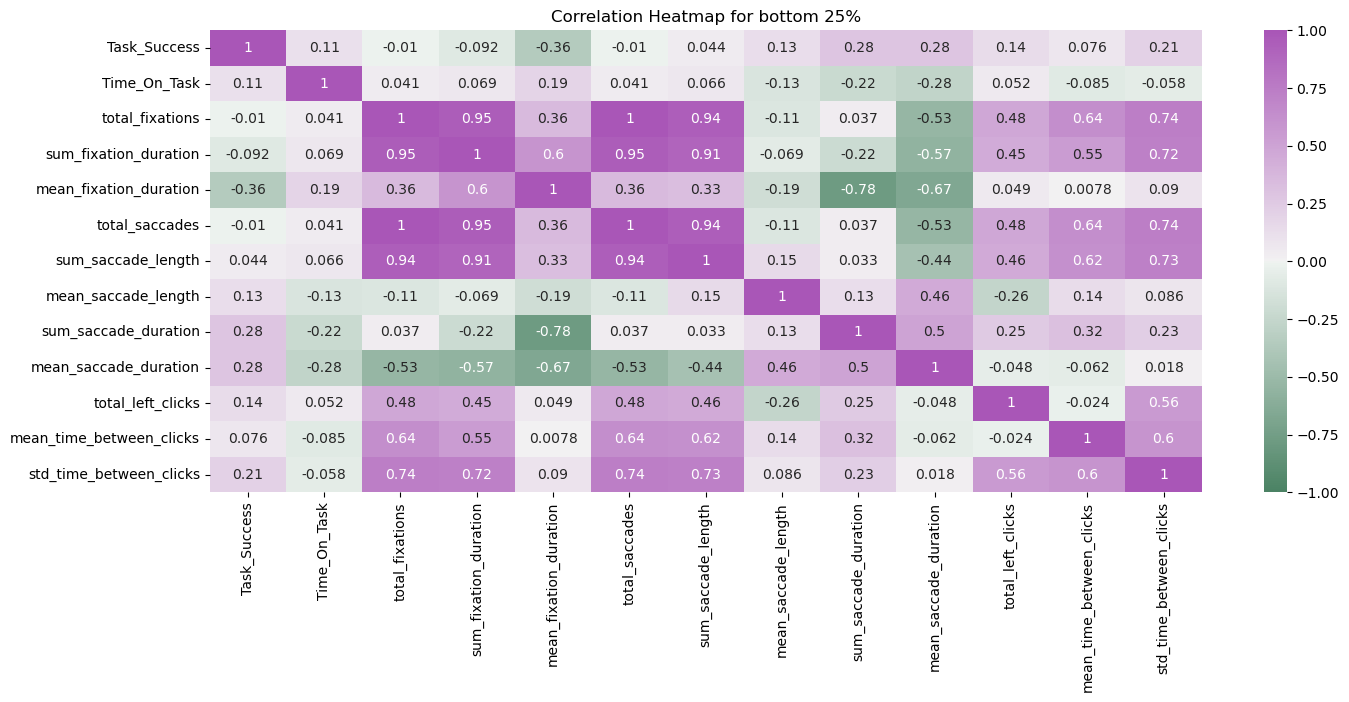

In [53]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap(bottom[corr_cols].corr(), vmin=-1, vmax=1, annot=True, 
                 cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True))
ax.set_title('Correlation Heatmap for bottom 25%')
plt.show()

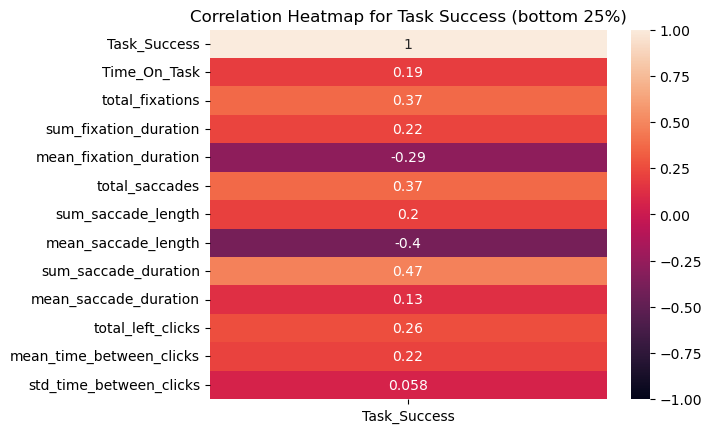

In [54]:
corr_succ = top[corr_cols].corr()[['Task_Success']]
ax = sns.heatmap(corr_succ, vmin=-1, vmax=1, annot=True)
ax.set_title('Correlation Heatmap for Task Success (bottom 25%)')
plt.show()

## Correlation plots

#### Time on task

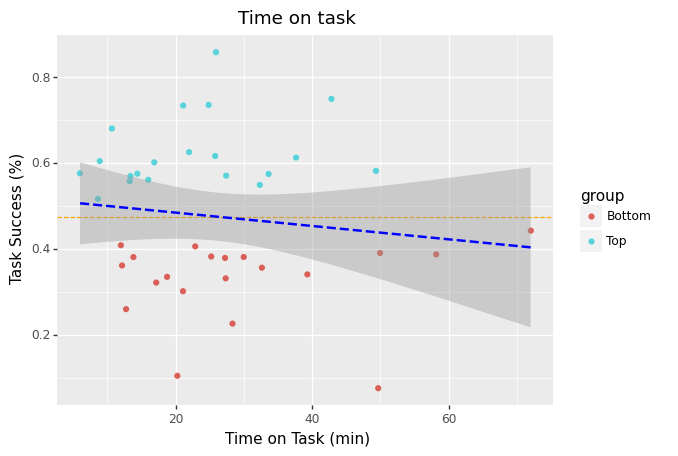

<ggplot: (118400466734)>

In [55]:
(
    ggplot(groups_metrics) +
    aes(x='Time_On_Task', y='Task_Success', color='group') +
    geom_jitter() + 
    geom_hline(yintercept = groups_metrics['Task_Success'].mean(),
              color = 'orange',
              linetype = 'dashed') +
    geom_smooth(method='lm', se=True,
              color = 'blue',
              linetype = 'dashed') +
    labs(x='Time on Task (min)', y='Task Success (%)',
        title='Time on task')
)

#### Total fixations

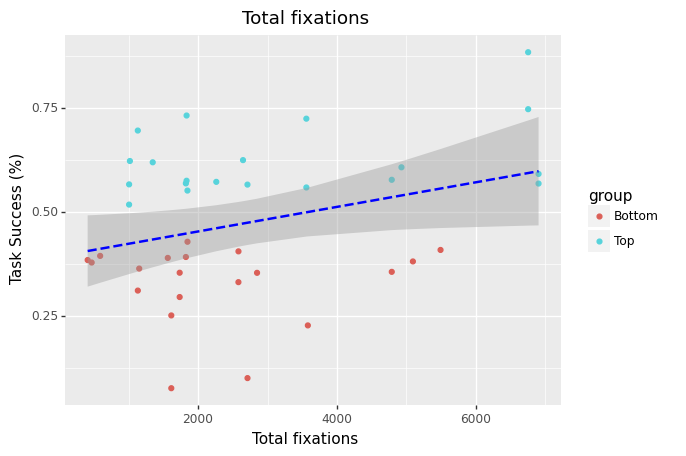

<ggplot: (118399473893)>

In [56]:
(
    ggplot(groups_metrics) +
    aes(x='total_fixations', y='Task_Success') +
    geom_jitter(aes(color='group')) + 
    geom_smooth(method='lm', se=True,
              color = 'blue',
              linetype = 'dashed') +
    labs(x='Total fixations', y='Task Success (%)',
        title='Total fixations')    
)

#### Mean fixations durations

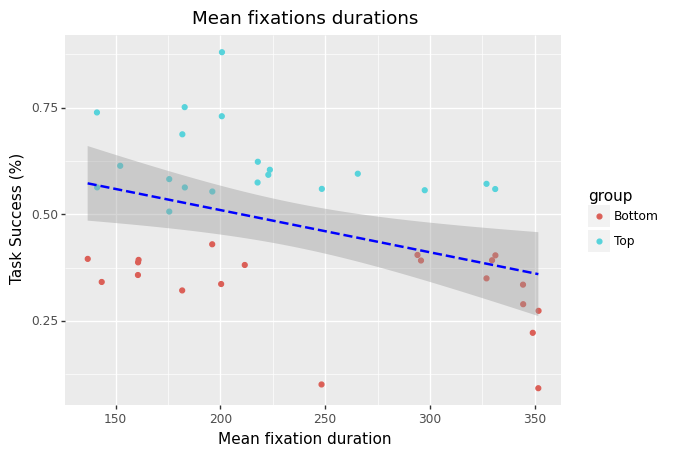

<ggplot: (118400336282)>

In [57]:
(
    ggplot(groups_metrics) +
    aes(x='mean_fixation_duration', y='Task_Success', color='group') +
    geom_jitter() +
    geom_smooth(method='lm', se=True,
              color = 'blue',
              linetype = 'dashed') +
    labs(x='Mean fixation duration', y='Task Success (%)',
        title='Mean fixations durations')    
)

#### Mean time between clicks

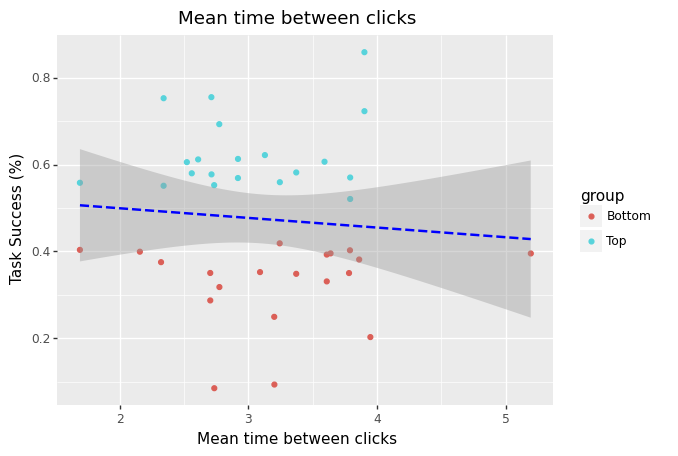

<ggplot: (118400249372)>

In [58]:
(
    ggplot(groups_metrics) +
    aes(x='mean_time_between_clicks', y='Task_Success', color='group') +
    geom_jitter() +
    geom_smooth(method='lm', se=True,
              color = 'blue',
              linetype = 'dashed') +
    labs(x='Mean time between clicks', y='Task Success (%)',
        title='Mean time between clicks')    
)

# Other analysis

In [59]:
# Look for other conclusions base on no evidence that support that any factor shared by the top 25% 
# gave them and advantage in performing better in their tasks